# Create Vector Datasets

This notebook contains general instructions for the creation of the vector data sets required by ScrollStats. 

An example dataset of a bend from the Lower Brazos River, Texas, is included in this notebook to provide a visual aid to the user when creating datasets for their own bend. 

Some datasets need to be manually created while others are programatically generated from the manually created datasets. 

---

ScrollStats uses the following vector datasets for a bend in order to calculate ridge metrics:
- **Channel Centerline (LineString):**
    - The channel centerline polyline should not intersect the bend boundary polygon at all and should extend past inner bank of the bend boundary by 1-2 channel widths.
- **Bend Boundary (Polygon):** 
    - The bend boundary in this case defines the boundary encompasses the raised platform of ridge and swale topography between the active channel and the relatively smooth ancestral floodplain. Each bend boundary should have a corresponding bend_id that can be used to relate data together. For example, the 25th bend on the Lower Brazos River was given the beind_id `LBR_025`.
- **Packet Boundaries (Polygon):**
    - The packet boundaries are polygons that fit perfectly within, and conver entirely, the bend boundary polygons. Packet boundaries encompass groups of ridges with similar trajectories. Packet boundaries should have `bend_id` column as well as a `packet_id` column. The `bend_id` can be used as a foreign key to relate the packets to their bend and the simple `packet_id` (ex. `p_01`) can be used to diffferentiate the packets within each bend. There is no guarantee of an inherent order with packets, but in gernal, they can and should be numbered incrementally from the most ancestral to the most recent.
- **Ridges (LineString):**
    - Ridges are manually created for each ridge on the bend. Ridge polylines can be created before the raster ridge classification process, however it is reccommended that the binary ridge area rasters be used to help inform the creation of ridge polylines. Ridge polylines should have a `bend_id` column, a `ridge_id` column, and optionally a `packet_id` column if packets are used. The `bend_id` and optional `packet_id` columns can be used as foreign keys to relate ridges to the larger morphological features and the simple `ridge_id` (ex. `r_001`) can be used to differentiate ridges within a bend. To a greater degree than the packets, there is no guarantee of an inherent order to the ridges on a given bend. However, as seen in the accompanying manuscript, ridges often can, but are not guaranteed to, be ordered within packets.
- **Migration Pathways (LineString):**
    - Migration pathways are algorithmically generated from the channel centerline and a set of ridges. The user specifies a set of starting points along the centerline from which the migration pathways will be generated. The migration pathway algorithm will "walk" up the flood plain until it fails to intersect any more ridges. The resulting migration pathways represent the varied paths of migration along a bend according to the depositional record contained in the ridge and swale topography

**Note on point density for channel centerline and ridgelines**

> A high vertex density and high degree of "smoothness" are necesarry for both the channel centerline and ridge lines when creating the migration pathways. It is reccommended that you focus on capturing the overall ridge form, not point density, when delineating. Then, the coarse polylines can be densified and smoothed with the included [line_smoother.py](scrollstats/delineation/line_smoother.py) script. 

---

While all of these above datasets are used, not all are strictly necesarry, not all are required at the beginning of the workflow, and some are generated from ScrollStats. 

The details of use for each of these datasets are summarized below:

**Required for Raster Processing**:
- Bend Boundary: the bend boundary is a required input from the user and is required for the raster processing. The bend boundary is the manual delineation of the topographically rasied platform that conatians the ridge and swale topography of a bend.

**Required for Migration Pathway Creation**
- Channel Centerline: the channel centerline generally follows the path of the water surface and should not intersect the bend boundary at all. The channel centerline should also extend past the channel-ward edges of the bend boundary. *See note at the end of this cell on point density for channel centerline and ridge lines.*

- Ridges: ridges are manually created and should track the middle of each ridge area. While it is not necesarry, it's strongly reccommended that both the DEM and ridge area raster be used to infer ridge line locations. *See note at the end of this cell on point density for channel centerline and ridge lines.*

**Used for ridge metric calculation**
- Migration Pathways: migration pathways are created by ScrollStats, so the user does not need to worry about creating these as an input. Migration pathways are a series of transects that trace the supposed path of channel migration from the channel centerline. Migration pathways are used to sample both the DEM and ridge area raster to calculate ridge width, amplitude, and spacing for every point intersection of the migration pathways and ridge lines.

- Packet Boundaries (optional): packet boundaries are the manual delineations of the depositional packets within a bend that contain groups of ridges with similar trajectorties. Packet boundaries fit perfectly within and cover entirely the bend boundary. Providing packet boundaries gives allows the user to aggregate ridge metrics to the packet scale in order to investigate changes in the hydrologic regime of the river.



In [1]:
from pathlib import Path

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from scrollstats import LineSmoother, create_transects
from parameters import SMOOTHING_WINDOW_SIZE, VERTEX_SPACING, SHOOT_DISTANCE, SEARCH_DISTANCE, DEV_FROM_90

## Create Bend Boundaries

Use a desktop GIS software (QGIS, ArcGIS Pro, etc.) to manually delineate the bend boundaries.

If there multiple bends delineated for the same river, it is reccommended to make 1 layer for the entire river and just add each bend as a feature (row) for that layer. Additionally, each bend should have a short, unique ID that is shared with the DEMs. For example, the 25th bend along the Lower Brazos River (starting from Waco TX) is given the ID `LBR_025`.

At this stage, it is reccommended to create the optional packet boundaries as well. Similarly to the bend boundaries, it is reccommended to make one layer for all the packets in the river and just add each packet as a feature (row). Add a "bend_id" column and a "packet_id" column. The bend id should correspond to the bend_id of the encompassing boundary and it is reccommended to have use a simple incrementing packet id that corresponds to the apparent evolution of the bend. For example, the most ancestral packet of `LBR_025` has the packet_id of `p_01` and the most recent, channelward packet has a packet_id of `p_04`. The combination of the bend_id and packet_id columns forms the primary key for the packets. 

Example bend and packet boundaries can be found in the [example_data](example_data) directory. These boundaries are mapped below.

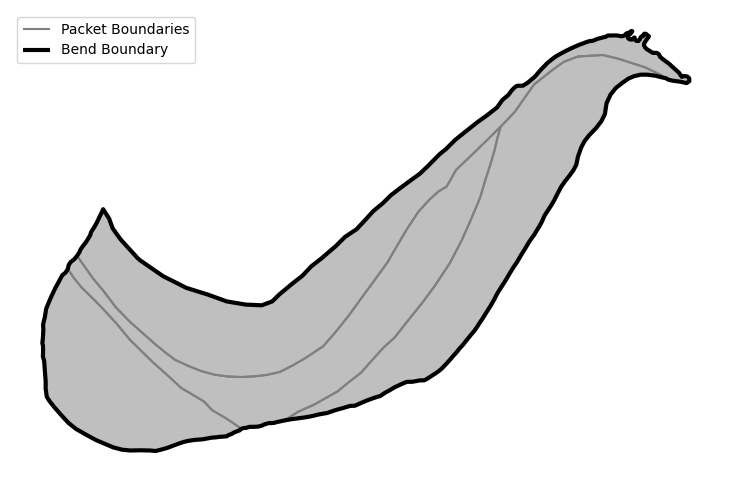

In [2]:
bend_area = gpd.read_file("example_data/input/LBR_025_bend.geojson").set_index("bend_id")
packets = gpd.read_file("example_data/input/LBR_025_packets.geojson").set_index("packet_id")

fig, ax = plt.subplots(1,1, figsize=(10, 6))

packets.boundary.plot(color="grey", ax=ax, label="Packet Boundaries")
packets.plot(color="grey", alpha=0.5, ax=ax)
bend_area.boundary.plot(color="k", lw=3, ax=ax, label="Bend Boundary")

ax.legend(loc="upper left")
ax.set_axis_off()

## Create Channel Centerline and Ridgelines
After the ridge area rasters are created, manually create the ridge lines and channel centerlines.

Example centerline and ridgelines can be found in the [example_data](example_data) directory. The centerline and ridgelines are mapped below.

In [3]:
ridge_path = Path("example_data/input/LBR_025_ridges_manual.geojson")
manual_ridges = gpd.read_file(ridge_path)

# Centerline is already smoothed and densified
cl_path = Path("example_data/input/LBR_025_cl.geojson")
cl = gpd.read_file(cl_path)

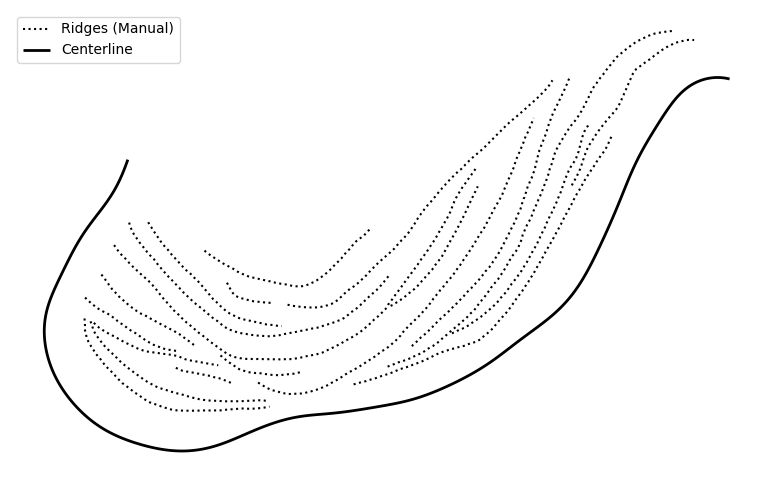

In [4]:
fig, ax = plt.subplots(1,1, figsize=(10, 6))

manual_ridges.plot(color="k", ls=":", ax=ax, label="Ridges (Manual)")
cl.plot(color="k", lw=2, ax=ax, label="Centerline")

ax.legend(loc="upper left")
ax.set_axis_off()

### Line Smoothing

Apply `LineSmoother` to smooth and densify the lines

In [5]:
window = SMOOTHING_WINDOW_SIZE
spacing = VERTEX_SPACING

# Smooth and densify the lines
ls = LineSmoother(manual_ridges, spacing, window)
smooth_ridges = ls.execute()

# Save smooth ridges to disk
output_dir = Path("example_data/output")
smooth_ridge_name = ridge_path.with_stem(ridge_path.stem + "_smoothed").name
smooth_ridge_path = output_dir / smooth_ridge_name

smooth_ridges.to_file(smooth_ridge_path, driver="GeoJSON", index=False)

# Plot manual and smoothed lines for comparison
m = manual_ridges.explore(color="black", style_kwds={"weight":5})
smooth_ridges.explore(color="red", m=m)

## Create Migration Pathways

Now that the ridges and centerlines are created, we can create the migration pathways

A migration pathway can be created from any point along the centerline. Below we will create an array of starting points each roughly a channel-width apart (~100m for the Lower Brazos). 

You can also create a set number of starting points by defining your `step` distance as the channel length divided by the number of evenly spaced transects. 

In [6]:
# define the distance between transects 
step = 100

# With a vertex spacing of ~1m, take every `step`th vertex along the centerline
starts = np.asarray(cl.geometry[0].xy).T[::step]

### Migration Pathway Algorithm
Our process involves ten major steps as follows:
1.	Let the channel centerline be called R1
2.	Select a starting point on R1, let this point be called P1
3.	From P1, shoot a given distance perpendicular from R1 in the direction of the convex bank.
4.	If the line intersects a ridge line, call this ridge R2 and proceed to step 5. If not, move on to the next location on R1 and repeat step 2.
5.	Where this new line intersects R2, make a new point and call it N1
6.	Buffer N1 by a given radius and search all vertices of R2 that intersect this buffer for a point from which a line may be drawn back to P1 that is perpendicular to R2. Call this new point on R2, N2.
7.	Treating the lines P1->N1 and P1->N2 as vectors, calculate their vertical resultant and place a new point at the end of this vertical resultant. Let this point be called VR. 
8.	Where the line P1->VR intersects R2, place a point and let this point be called P2. Line P1->P2 is the migration pathway for this location on the floodplain. 
9.	Redefine P2 as P1
10.	Repeat steps 3-9 until the perpendicular shot from P1 fails to intersect any ridges.

![Migration Pathway process](img/migration_pathway.png)

In [7]:
# Transect Parameters
shoot_distance = SHOOT_DISTANCE       # Distance that the N1 coordinate will shoot out from point P1; measured in linear unit of dataset
search_distance = SEARCH_DISTANCE     # Buffer radius used to search for an N2 coordinate on R2; measured in linear unit of dataset
dev_from_90 = DEV_FROM_90             # Max angular deviation from 90° allowed when searching for an N2 coordinate on R2; measured in degrees

transects = create_transects(cl, smooth_ridges, step, shoot_distance, search_distance, dev_from_90)

# Save transects to disk
transect_path = output_dir / "LBR_025_transects.geojson"
transects.to_file(transect_path, dirver="GeoJSON", index=True)


--- Walking Transect t_000 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_001 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_002 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_003 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_004 ---
TRANSECT TERMINATED (iter=0): n1 shot failed to intersect any more ridges.

--- Walking Transect t_005 ---
TRANSECT TERMINATED (iter=0): Failed to create n2 within a deviance of 5.0°

--- Walking Transect t_006 ---
Iteration 00 result: [n1: POINT (1066806.880544728 3111441.3653525687), n2: POINT (1066803.737014806 3111451.251164231), p2: POINT (1066805.093997941 3111446.2700663134)]
Iteration 01 result: [n1: POINT (1066830.7635832166 3111454.2471496607), n2: POINT (1066828.4586901155 3111458.5861036708), p2: POINT (1066829.597776729

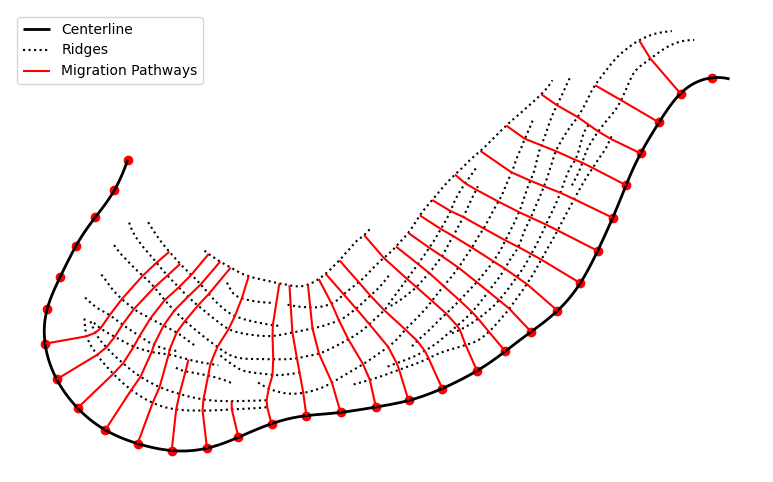

In [8]:
# Plot migration pathways alongside ridges and centerlines 
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

cl.plot(color="k", lw=2, ax=ax, label="Centerline")
smooth_ridges.plot(color="k", ls=":", ax=ax, label="Ridges")
transects.plot(color="r", ax=ax, label="Migration Pathways")
plt.scatter(starts[:, ::2], starts[:, 1::2], color="r")

ax.legend()
ax.set_axis_off()

## Move on to [`CalculateRidgeMetrics.ipynb`](CalculateRidgeMetrics.ipynb)
- All vector datasets needed for ScrollStats are now created.
- [`CalculateRidgeMetrics.ipynb`](CalculateRidgeMetrics.ipynb) will contain the example code to calculate ridge metrics from the ridges generated in this notebook and the ridge area raster created in [`DelineateRidgeAreas.ipynb`](DelineateRidgeAreas.ipynb)